# Import and misc

In [27]:
!pip install torchaudio==0.9.1
!pip install thop

In [28]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [29]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    max_window_length: int = 16000

# Data

In [30]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [31]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywords': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [32]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [33]:
dataset.csv.sample(5)

,path,keyword,label
16307,speech_commands/up/23abe1c9_nohash_2.wav,up,0
22866,speech_commands/on/7ea032f3_nohash_3.wav,on,0
32153,speech_commands/stop/76e53db9_nohash_0.wav,stop,0
21919,speech_commands/on/c0f8f4df_nohash_3.wav,on,0
27020,speech_commands/house/3d6bee47_nohash_0.wav,house,0


### Augmentations

In [34]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [35]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [36]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [37]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [38]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [39]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [40]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [41]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [42]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [43]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [44]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [45]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [46]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [47]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [48]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [49]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [50]:
sum([p.numel() for p in model.parameters()])

70443

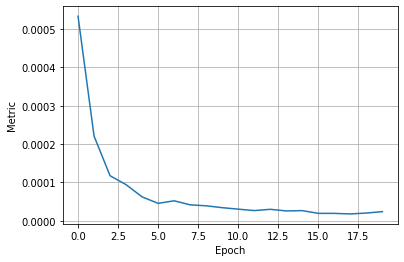

END OF EPOCH 19


In [25]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

# Streaming

In [135]:
@torch.no_grad()
class StreamingKWS:
    """Streaming KeyWord Spotting
    Attributes:
        config: TaskConfig
        model: Trained KWS model
        audio_file: Path to target audio file
    """
    def __init__(self, config: TaskConfig, model, audio_file):
        self.config = config
        self.max_window_length = config.max_window_length
        self.batch_size = config.batch_size
        self.model = model
        self.audio_file = audio_file

    @torch.no_grad()
    def __call__(self, softmax=False):
        self.model.eval()
        audio = torchaudio.load(self.audio_file)[0].to(self.config.device)
        length = audio.shape[1]
        slice_length = self.max_window_length+self.batch_size
        preds = []
        for i in tqdm(range(slice_length-1, length, self.batch_size)):
            slice = audio[:, i-slice_length+1:i]
            slice = slice[None, None]
            batch = F.unfold(slice, kernel_size=(1, self.batch_size)).squeeze(0)
            batch = melspec_val(batch)
            preds.append(self.model(batch))
        last_batch_size = length-i
        if last_batch_size > 0:
            slice = audio[:, length-last_batch_size-self.max_window_length+1:]
            slice = slice[None, None]
            batch = F.unfold(slice, kernel_size=(1, last_batch_size)).squeeze(0)
            batch = melspec_val(batch)
            preds.append(self.model(batch))
        preds = torch.cat(preds).cpu()
        if softmax:
            return F.softmax(preds, dim=-1)
        return preds

In [42]:
streaming = StreamingKWS(TaskConfig, model, 'norm.wav')
preds = streaming()
probs = F.softmax(preds, dim=-1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:06<00:00, 316.59it/s]


Первый график - чистый выход из модели, второй - вероятность (softmax). Ключевое слово примерно на timestep 150000, его легко можно выявить по графикам. Однако на других звуках модель также выдает довольно высокие вероятности, что не очень хорошо.

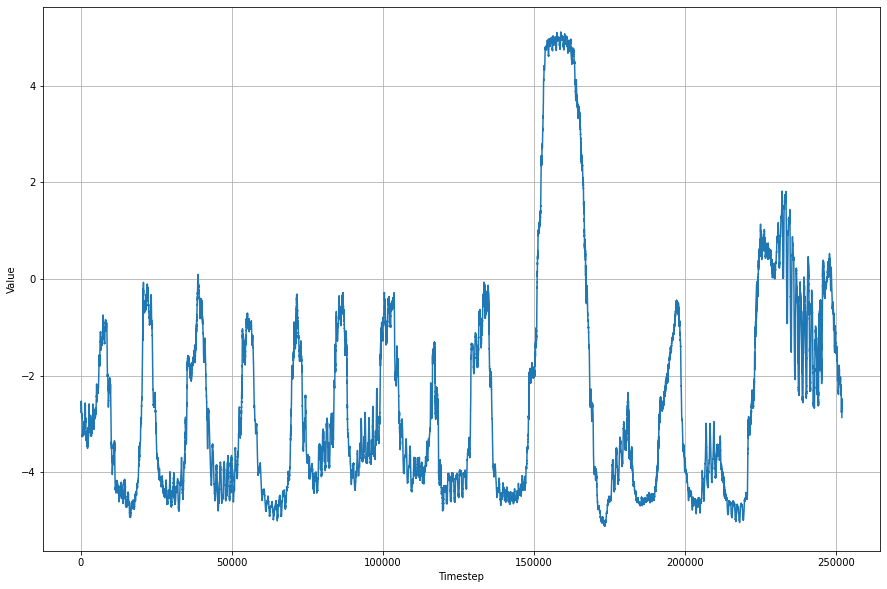

In [46]:
plt.figure(figsize=(15, 10))
plt.plot(preds[:, 1])
plt.ylabel('Value')
plt.xlabel('Timestep')
plt.grid()
plt.show()

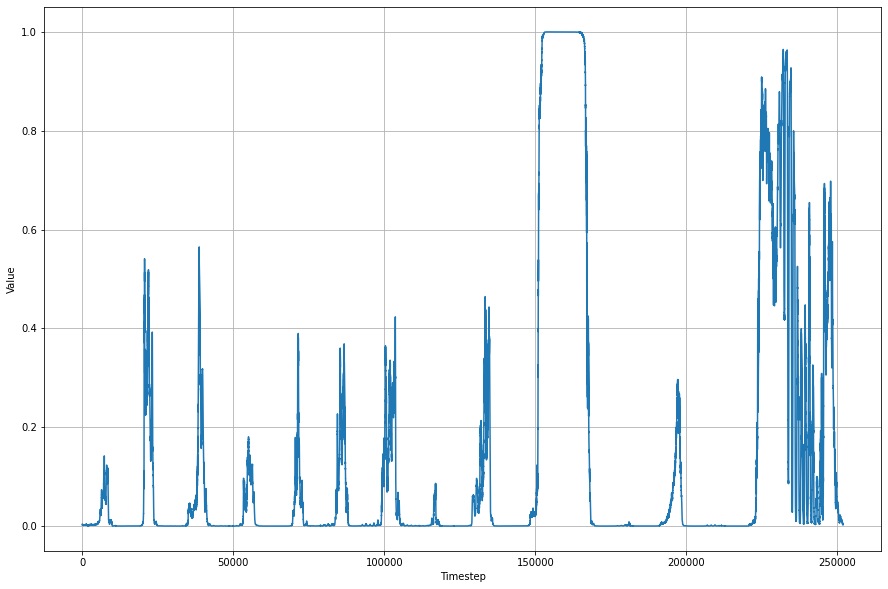

In [47]:
plt.figure(figsize=(15, 10))
plt.plot(probs[:, 1])
plt.ylabel('Value')
plt.xlabel('Timestep')
plt.grid()
plt.show()

# Distillation

Модель студента - урезанная стандартная модель. `hidden_size:64->16`, `cnn_out_channels:8->4`.

In [90]:
@dataclasses.dataclass
class StudentConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 40
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 16
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    max_window_length: int = 16000

class StudentCRNN(nn.Module):

    def __init__(self, config: StudentConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = StudentConfig()
student_model = StudentCRNN(config)
student_model

StudentCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

Количество параметров снизилось до 6679 (было около 70000).

In [91]:
sum([p.numel() for p in student_model.parameters()])

6679

Для дистиляции своя train функция: лосс складывается из обычного (кросс энтропия с таргетом) и дивиргенции КЛ с предсказанием модели-учителя. Сложение происходит с весами `alpha` и `(1-alpha)`.

In [111]:
def train_epoch_distil(model, opt, loader, log_melspec, device, teacher_model, T, alpha):
    model.train()
    teacher_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        with torch.no_grad():
            logits_teacher = teacher_model(batch)
        loss_student = F.cross_entropy(logits, labels)
        loss_teacher = torch.nn.KLDivLoss(reduction='sum')(F.log_softmax(logits/T, dim=-1), F.softmax(logits_teacher/T, dim=-1))
        loss = loss_student * alpha + loss_teacher * (1.-alpha)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

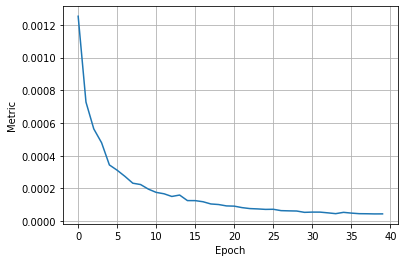

END OF EPOCH 39


In [113]:
# TRAIN STUDENT

history = defaultdict(list)
config = StudentConfig()
student_model = StudentCRNN(config).to(config.device)
opt = torch.optim.Adam(
    student_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

for n in range(StudentConfig.num_epochs):

    train_epoch_distil(student_model, opt, train_loader,
                melspec_train, config.device, model, 20, 0.5)

    au_fa_fr = validation(student_model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()


    print('END OF EPOCH', n)
    if history['val_metric'][-1] < 0.00004:
        break

Для достижения нужного качества пришлось увеличить число эпох.

In [114]:
history

defaultdict(list,
            {'val_metric': [0.0012534057912960634,
              0.0007278916162073222,
              0.0005638974411305161,
              0.0004790747198124519,
              0.00034322648290200644,
              0.00031070931613247414,
              0.00027294070749155476,
              0.00023141851142210985,
              0.0002232131334980675,
              0.00019505526023654466,
              0.00017517139169624706,
              0.00016670045790484478,
              0.00015025688054506387,
              0.0001589068407638998,
              0.0001249425437059455,
              0.00012478440369504578,
              0.00011791874020296524,
              0.00010436643964623783,
              0.00010082768393063262,
              9.241940938883213e-05,
              9.099913306452515e-05,
              8.194636338396351e-05,
              7.609219920688309e-05,
              7.402444397002441e-05,
              7.115106980971431e-05,
              7.180153249605657

In [285]:
from thop import profile  # !pip install thop
import tempfile
import copy

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

def get_macs_param(model):
    temp_model = copy.deepcopy(model).to('cpu')
    random_batch = torch.rand((config.batch_size, TaskConfig.n_mels, 101))
    return profile(temp_model, (random_batch,))



macs_student, param_student = get_macs_param(student_model)
macs_teacher, param_teacher = get_macs_param(model)

student_size = get_size_in_megabytes(student_model)
teacher_size = get_size_in_megabytes(model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.StudentCRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.contain

In [286]:
print(f"Student MAC: {macs_student}")
print(f"Teacher MAC: {macs_teacher}")

Student MAC: 19321856.0
Teacher MAC: 119527424.0


In [287]:
print(f"MACs ratio: {macs_teacher/macs_student}")
print(f"Size ratio: {teacher_size/student_size}")
print(f"Params student: {param_student}")
print(f"Params teacher: {param_teacher}")

MACs ratio: 6.186125390852721
Size ratio: 9.45763554966009
Params student: 6679.0
Params teacher: 70443.0


Улучшение скорости (расчитывая по MAC) в `6.19` раз. Уменьшение модели в `9.45` раз.

# Quantization

Для начала квантизация стандартной модели:

In [342]:
class CPUconf:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 40
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 16
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = 'cpu'
    max_window_length: int = 16000

cpu_melspec_val = LogMelspec(is_train=False, config=CPUconf)

def model_quantization(inp_model, do_stats=True):
    device = CPUconf.device
    my_model = copy.deepcopy(inp_model).to(device)
    quant_model  = torch.quantization.quantize_dynamic(my_model, {nn.GRU, nn.Linear, nn.Conv2d}, dtype=torch.qint8)

    if do_stats:
        print(f"Validation: {validation(quant_model, val_loader, cpu_melspec_val, device=device)}")
        size = get_size_in_megabytes(quant_model)
        print(f"Size: {size}")
        random_batch = torch.rand((config.batch_size, TaskConfig.n_mels, 101))
        mac, param = profile(quant_model, (random_batch,))
        print(f"MAC and params: {mac, param}")
        return (quant_model, size, mac, param)
    return quant_model

In [289]:
quant_model, qteacher_size, qteacher_mac, qteacher_param = model_quantization(model)

102it [00:03, 25.84it/s]


Validation: 1.8278598240975838e-05
Size: 0.07870769500732422
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Ca

In [290]:
print(f"MACs ratio: {macs_teacher/qteacher_mac}")
print(f"Size ratio: {teacher_size/ qteacher_size}")

MACs ratio: 5.836883688368837
Size ratio: 3.4556106190401183


Ускорение в `5.84`, уменьшение в `3.47` раз.

Теперь квантизируем модель студента:

In [291]:
student_quant_model, qstudent_size, qstudent_mac, qstudent_param = model_quantization(student_model)

102it [00:03, 28.75it/s]


Validation: 4.125962397587559e-05
Size: 0.014925956726074219
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Ca

In [292]:
print(f"MACs ratio: {macs_teacher/qstudent_mac}")
print(f"Size ratio: {teacher_size/qstudent_size}")

MACs ratio: 11.673767376737674
Size ratio: 18.22215832854131


Ускорение в `11.67`, уменьшение в `18.29` раз относительно изначальной модели (учителя). Относительно студента:

In [293]:
print(f"MACs ratio: {macs_student/qstudent_mac}")
print(f"Size ratio: {student_size/qstudent_size}")

MACs ratio: 1.8870887088708872
Size ratio: 1.9267139479905437


In [296]:
val_teacher = validation(model, val_loader, melspec_val, device=TaskConfig.device)
val_student = validation(student_model, val_loader, melspec_val, device=TaskConfig.device)
val_qteacher = validation(quant_model, val_loader, cpu_melspec_val, device='cpu')
val_qstudent = validation(student_quant_model, val_loader, cpu_melspec_val, device='cpu')

102it [00:01, 64.54it/s]
102it [00:01, 64.56it/s]
102it [00:03, 26.99it/s]
102it [00:03, 27.06it/s]


In [297]:
print(f"{val_teacher=}")
print(f"{val_student=}")
print(f"{val_qteacher=}")
print(f"{val_qstudent=}")

val_teacher=1.735362836590197e-05
val_student=4.364664300832428e-05
val_qteacher=1.8278598240975838e-05
val_qstudent=4.125962397587559e-05


In [303]:
results = pd.DataFrame({
    'size':[teacher_size, student_size, qteacher_size, qstudent_size],
    'MAC':[macs_teacher, macs_student, qteacher_mac, qstudent_mac],
    'param':[param_teacher, param_student, qteacher_param, qstudent_param],
    'metric':[val_teacher, val_student, val_qteacher, val_qstudent]
}, ['teacher', 'student', 'quant_teacher', 'quant_student'])

# Final Results

Итоговые результаты:

In [304]:
results

,size,MAC,param,metric
teacher,0.271983,119527424.0,70443.0,0.000017
student,0.028758,19321856.0,6679.0,0.000044
quant_teacher,0.078708,20477952.0,808.0,0.000018
quant_student,0.014926,10238976.0,404.0,0.000041


Уменьшение относительно teacher:

In [315]:
1/(results/results.loc['teacher', :])

,size,MAC,param,metric
teacher,1.000000,1.000000,1.000000,1.000000
student,9.457636,6.186125,10.546938,0.397594
quant_teacher,3.455611,5.836884,87.181931,0.949396
quant_student,18.222158,11.673767,174.363861,0.420596


# Final models

In [347]:
model = CRNN(TaskConfig)
model.load_state_dict(torch.load('saved_model'))
student_model = StudentCRNN(StudentConfig)
student_model.load_state_dict(torch.load('student_model_distil_40epoch'))
model.to(TaskConfig.device)
student_model.to(TaskConfig.device)

quant_model = CRNN(TaskConfig)
quant_model.load_state_dict(torch.load('saved_model'))
quant_model = model_quantization(quant_model, do_stats=False)

student_quant_model = CRNN(StudentConfig)
student_quant_model.load_state_dict(torch.load('student_model_distil_40epoch'))
student_quant_model = model_quantization(student_quant_model, do_stats=False)

In [349]:
val_teacher = validation(model, val_loader, melspec_val, device=TaskConfig.device)
val_student = validation(student_model, val_loader, melspec_val, device=TaskConfig.device)
val_qteacher = validation(quant_model, val_loader, cpu_melspec_val, device='cpu')
val_qstudent = validation(student_quant_model, val_loader, cpu_melspec_val, device='cpu')

print(f"{val_teacher=}")
print(f"{val_student=}")
print(f"{val_qteacher=}")
print(f"{val_qstudent=}")

102it [00:01, 64.31it/s]
102it [00:01, 63.69it/s]
102it [00:03, 26.16it/s]
102it [00:03, 28.64it/s]


val_teacher=1.735362836590197e-05
val_student=4.364664300832428e-05
val_qteacher=1.8278598240975838e-05
val_qstudent=4.125962397587559e-05


In [358]:
@torch.no_grad()
class CPUStreamingKWS:
    """Streaming KeyWord Spotting
    Attributes:
        config: TaskConfig
        model: Trained KWS model
        audio_file: Path to target audio file
    """
    def __init__(self, config: TaskConfig, model, audio_file):
        self.config = config
        self.max_window_length = config.max_window_length
        self.batch_size = config.batch_size
        self.model = model
        self.audio_file = audio_file

    @torch.no_grad()
    def __call__(self, softmax=False):
        self.model.eval()
        audio = torchaudio.load(self.audio_file)[0]
        length = audio.shape[1]
        slice_length = self.max_window_length+self.batch_size
        preds = []
        for i in tqdm(range(slice_length-1, length, self.batch_size)):
            slice = audio[:, i-slice_length+1:i]
            slice = slice[None, None]
            batch = F.unfold(slice, kernel_size=(1, self.batch_size)).squeeze(0)
            batch = cpu_melspec_val(batch)
            preds.append(self.model(batch))
        last_batch_size = length-i
        if last_batch_size > 0:
            slice = audio[:, length-last_batch_size-self.max_window_length+1:]
            slice = slice[None, None]
            batch = F.unfold(slice, kernel_size=(1, last_batch_size)).squeeze(0)
            batch = cpu_melspec_val(batch)
            preds.append(self.model(batch))
        preds = torch.cat(preds).cpu()
        if softmax:
            return F.softmax(preds, dim=-1)
        return preds

In [359]:
streaming = CPUStreamingKWS(CPUconf, student_quant_model, 'norm.wav')
preds = streaming()
probs = F.softmax(preds, dim=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1967/1967 [01:06<00:00, 29.38it/s]


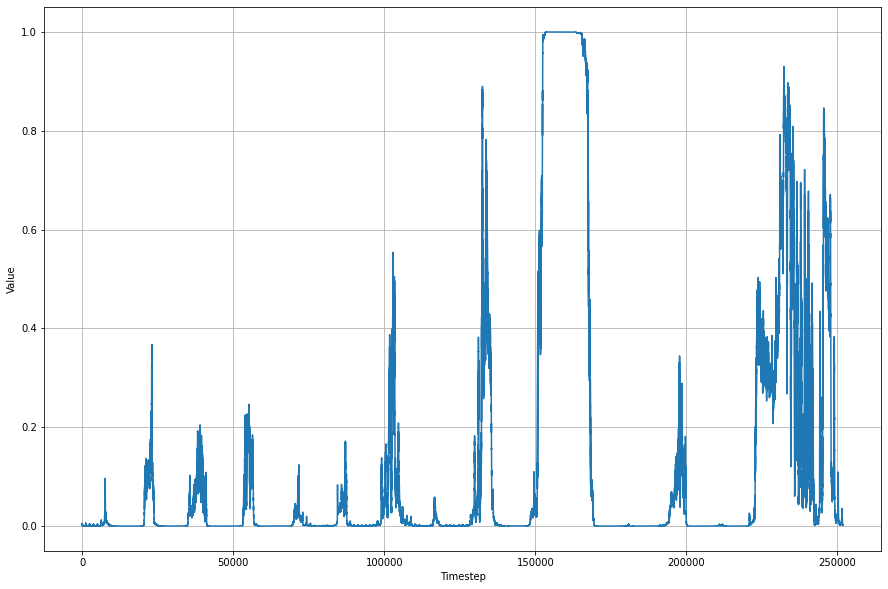

In [360]:
plt.figure(figsize=(15, 10))
plt.plot(probs[:, 1])
plt.ylabel('Value')
plt.xlabel('Timestep')
plt.grid()
plt.show()